In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 36.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 52.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 49.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 77.7 MB/s eta 0:00:00:00:0100:01


/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.4.33 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


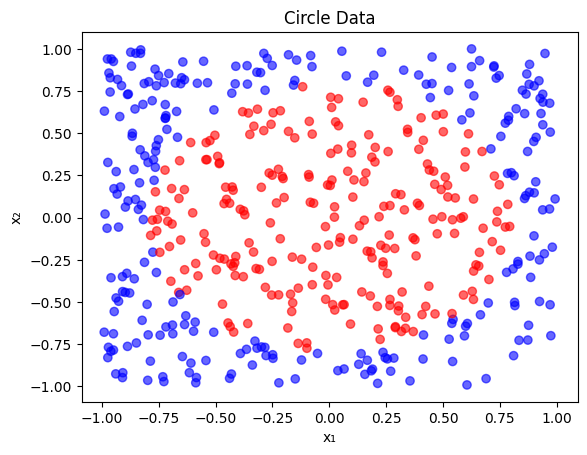


=== Running for 1 qubit(s) ===
[DRC 1q×6L] Epoch  1  MSE 0.9020
[DRC 1q×6L] Epoch  2  MSE 0.6660
[DRC 1q×6L] Epoch  3  MSE 0.4847
[DRC 1q×6L] Epoch  4  MSE 0.4461
[DRC 1q×6L] Epoch  5  MSE 0.4081
[DRC 1q×6L] Epoch  6  MSE 0.3779
[DRC 1q×6L] Epoch  7  MSE 0.3587
[DRC 1q×6L] Epoch  8  MSE 0.3464
[DRC 1q×6L] Epoch  9  MSE 0.3176
[DRC 1q×6L] Epoch 10  MSE 0.3341
[DRC 1q×6L] Epoch 11  MSE 0.3071


In [ ]:
import numpy as np
import torch
import pennylane as qml
from torch.utils.data import TensorDataset, DataLoader
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ────────────────────────────────────────────────────────────────────────────────
# 0) Hyperparameters
# ────────────────────────────────────────────────────────────────────────────────
lr          = 0.1
epochs      = 30
batch_size  = 32
angle_scale = np.pi  # we map ||x||=radius→π to center the decision boundary

# ────────────────────────────────────────────────────────────────────────────────
# 1) Generate & plot circle data
# ────────────────────────────────────────────────────────────────────────────────
def circle(samples, center=(0,0), radius=np.sqrt(2/np.pi)):
    X, y = [], []
    for _ in range(samples):
        pt = 2*np.random.rand(2) - 1
        X.append(pt)
        y.append(int(np.linalg.norm(pt-center) < radius))
    return np.array(X), np.array(y)

np.random.seed(42)
X, y = circle(500)
plt.scatter(X[:,0], X[:,1], c=y, cmap="bwr", alpha=0.6)
plt.title("Circle Data"); plt.xlabel("x₁"); plt.ylabel("x₂")
plt.show()

# train/test split
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# for MSE‐based training map {0,1}→{−1,+1}
y_train_pm = 2*y_train_np - 1
y_test_pm  = 2*y_test_np  - 1

# torch tensors & loader
X_train = torch.tensor(X_train_np, dtype=torch.float64)
y_train = torch.tensor(y_train_pm, dtype=torch.float64)
X_test  = torch.tensor(X_test_np,  dtype=torch.float64)
y_test  = torch.tensor(y_test_pm,  dtype=torch.float64)

train_loader = DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=batch_size, shuffle=True
)

# ────────────────────────────────────────────────────────────────────────────────
# 2) Data‐reuploading trainer factory
# ────────────────────────────────────────────────────────────────────────────────
def make_drc_trainer(n_qubits, n_layers):
    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev, interface="torch")
    def qnode(x, weights):
        # reupload & processing per layer
        for l in range(n_layers):
            # embed both features on each wire
            for i in range(n_qubits):
                qml.RX(angle_scale * x[0], wires=i)
                qml.RY(angle_scale * x[1], wires=i)
            # one entangling variational block
            block = weights[l : l+1]  # shape (1, n_qubits, 3)
            qml.templates.StronglyEntanglingLayers(block, wires=range(n_qubits))
        # measure average Z
        obs    = [qml.PauliZ(i) for i in range(n_qubits)]
        coeffs = [1.0 / n_qubits] * n_qubits
        H      = qml.Hamiltonian(coeffs, obs)
        return qml.expval(H)

    def train_and_eval():
        # init weights
        weights = torch.nn.Parameter(
            0.1 * torch.randn(n_layers, n_qubits, 3),
            requires_grad=True
        )
        opt     = torch.optim.Adam([weights], lr=lr)
        loss_fn = torch.nn.MSELoss()

        # training loop
        for ep in range(1, epochs+1):
            tot = 0.0
            for xb, yb in train_loader:
                opt.zero_grad()
                preds = torch.stack([qnode(x_i, weights) for x_i in xb])
                loss  = loss_fn(preds, yb)
                loss.backward()
                opt.step()
                tot += loss.item() * xb.shape[0]
            if ep >= 0:
                print(f"[DRC {n_qubits}q×{n_layers}L] Epoch {ep:2d}  MSE {tot/len(train_loader.dataset):.4f}")

        # evaluation
        def evaluate():
            raw   = [qnode(x, weights).item() for x in X_test]
            # threshold >0 → label 1, else 0
            preds = [1 if v > 0 else 0 for v in raw]
            return accuracy_score(y_test_np, preds)

        return evaluate

    return train_and_eval

# ────────────────────────────────────────────────────────────────────────────────
# 3) Single‐block variational trainer factory
# ────────────────────────────────────────────────────────────────────────────────
def make_var_trainer(n_qubits):
    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev, interface="torch")
    def qnode(x, weights):
        # embed
        for i in range(n_qubits):
            qml.RX(angle_scale * x[0], wires=i)
            qml.RY(angle_scale * x[1], wires=i)
        # single Rot per wire
        block = weights[0:1]
        qml.templates.StronglyEntanglingLayers(block, wires=range(n_qubits))
        # measure Z₀
        return qml.expval(qml.PauliZ(0))

    def train_and_eval():
        weights = torch.nn.Parameter(
            0.1 * torch.randn(1, n_qubits, 3),
            requires_grad=True
        )
        opt     = torch.optim.Adam([weights], lr=lr)
        loss_fn = torch.nn.MSELoss()

        for ep in range(1, epochs+1):
            tot = 0.0
            for xb, yb in train_loader:
                opt.zero_grad()
                preds = torch.stack([qnode(x_i, weights) for x_i in xb])
                loss  = loss_fn(preds, yb)
                loss.backward()
                opt.step()
                tot += loss.item() * xb.shape[0]
            if ep % 10 == 0:
                print(f"[VAR {n_qubits}q] Epoch {ep:2d}  MSE {tot/len(train_loader.dataset):.4f}")

        def evaluate():
            raw   = [qnode(x, weights).item() for x in X_test]
            preds = [1 if v > 0 else 0 for v in raw]
            return accuracy_score(y_test_np, preds)

        return evaluate

    return train_and_eval

# ────────────────────────────────────────────────────────────────────────────────
# 4) Implicit‐kernel SVM (nested loops, bug‐fixed)
# ────────────────────────────────────────────────────────────────────────────────
def make_kernel_runner(n_qubits, subsample=200):
    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev, interface="torch")
    def fidelity_qnode(x1, x2):
        # two re‐uploads per wire
        for _ in range(2):
            for i in range(n_qubits):
                qml.RX(angle_scale * x1[0], wires=i)
                qml.RY(angle_scale * x1[1], wires=i)
        # un-encode x2
        for _ in range(2):
            for i in range(n_qubits):
                qml.adjoint(qml.RY)(angle_scale * x2[1], wires=i)
                qml.adjoint(qml.RX)(angle_scale * x2[0], wires=i)
        # average Z across wires
        obs    = [qml.PauliZ(i) for i in range(n_qubits)]
        coeffs = [1.0 / n_qubits] * n_qubits
        H      = qml.Hamiltonian(coeffs, obs)
        # expval(H)∈[−1,1], fidelity = (1+⟨H⟩)/2
        return qml.expval(H)

    def run():
        # subsample training
        N = min(subsample, len(X_train_np))
        idxs = np.random.choice(len(X_train_np), N, replace=False)
        X_sub = X_train_np[idxs]
        y_sub = (y_train_np[idxs] > 0).astype(int)

        # build Gram matrices
        K_train = np.zeros((N, N))
        for i, a in enumerate(X_sub):
            for j, b in enumerate(X_sub):
                zv = fidelity_qnode(torch.tensor(a), torch.tensor(b)).item()
                K_train[i, j] = 0.5 * (1 + zv)

        M = len(X_test_np)
        K_test = np.zeros((M, N))
        for i, a in enumerate(X_test_np):
            for j, b in enumerate(X_sub):
                zv = fidelity_qnode(torch.tensor(a), torch.tensor(b)).item()
                K_test[i, j] = 0.5 * (1 + zv)

        svc    = SVC(kernel="precomputed").fit(K_train, y_sub)
        preds  = svc.predict(K_test)
        return accuracy_score(y_test_np, preds)

    return run

# ────────────────────────────────────────────────────────────────────────────────
# 5) Run them all for n_qubits=1, n_layers=6
# ────────────────────────────────────────────────────────────────────────────────
results = []

# Run all 3 models for n_qubits = 1 to 12
for n_q in range(1, 13):
    print(f"\n=== Running for {n_q} qubit(s) ===")

    # DRC: 6-layer reuploading
    drc_runner = make_drc_trainer(n_q, n_layers=6)
    drc_eval   = drc_runner()
    drc_acc    = drc_eval()

    # VAR: single variational layer
    var_runner = make_var_trainer(n_q)
    var_eval   = var_runner()
    var_acc    = var_eval()

    # Kernel SVM: subsample to 200
    ker_runner = make_kernel_runner(n_q)
    ker_acc    = ker_runner()

    print(f"[Qubits={n_q}] DRC: {drc_acc:.3f}, VAR: {var_acc:.3f}, KER: {ker_acc:.3f}")
    results.append((n_q, drc_acc, var_acc, ker_acc))

# Pretty print results
print("\nSummary:")
print(f"{'Qubits':>6} | {'DRC':>6} | {'VAR':>6} | {'KER':>6}")
print("-" * 32)
for q, d, v, k in results:
    print(f"{q:6d} | {d:6.3f} | {v:6.3f} | {k:6.3f}")
qubits, drc_vals, var_vals, ker_vals = zip(*results)
plt.plot(qubits, drc_vals, label="Data Reuploading")
plt.plot(qubits, var_vals, label="Variational")
plt.plot(qubits, ker_vals, label="Kernel SVM")
plt.xlabel("Number of Qubits")
plt.ylabel("Test Accuracy")
plt.title("Model Accuracy vs Qubit Count")
plt.legend()
plt.grid(True)
plt.show()